In [16]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import pearsonr

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypcd.csv')
tm = pd.read_csv(fp)
tm.drop(columns=['Unnamed: 0'], inplace=True)
tm.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry', 'SpeciesName', 'spp_pct', 'forest_pct',
       'count', 'total_pixels'],
      dtype='object')

In [3]:
# load the CBI data
fp = os.path.join(projdir,'data/earth-engine/exports/cbi/gridstats_cbi_rbr.csv')
sev = pd.read_csv(fp)
sev.drop(columns=['system:index','.geo'], inplace=True)
sev.columns

Index(['CBIbc_mean', 'CBIbc_p90', 'CBIbc_p95', 'CBIbc_p99', 'CBIbc_stdDev',
       'RBR_mean', 'RBR_p90', 'RBR_p95', 'RBR_p99', 'RBR_stdDev',
       'grid_index'],
      dtype='object')

In [4]:
# merge the dataframes
tm_sev = tm.merge(sev, on='grid_index', how='inner')
tm_sev[['grid_index','SpeciesName','spp_pct','forest_pct','frp_csum','frp_max','CBIbc_mean','CBIbc_p90']].head()

,grid_index,SpeciesName,spp_pct,forest_pct,frp_csum,frp_max,CBIbc_mean,CBIbc_p90
0,822559,Aspen,62.868272,96.107206,0.036369,0.036369,0.219495,0.42
1,822559,Douglas-fir,1.096010,96.107206,0.036369,0.036369,0.219495,0.42
2,822559,Lodgepole,0.723076,96.107206,0.036369,0.036369,0.219495,0.42
3,822559,Ponderosa,3.093275,96.107206,0.036369,0.036369,0.219495,0.42
4,822559,Spruce-fir,31.162723,96.107206,0.036369,0.036369,0.219495,0.42


In [5]:
# filter to majority forested grid cells
tm_sev_forest = tm_sev[tm_sev['forest_pct'] > 50]
len(tm_sev_forest['grid_index'].unique())

41955

In [6]:
# identify the dominant forest type
tm_sev_d = tm_sev_forest.loc[tm_sev_forest.groupby('grid_index')['spp_pct'].idxmax()]
print(tm_sev_d['SpeciesName'].unique())

['Piñon-juniper' 'Ponderosa' 'Aspen' 'Douglas-fir' 'Lodgepole'
 'Spruce-fir']


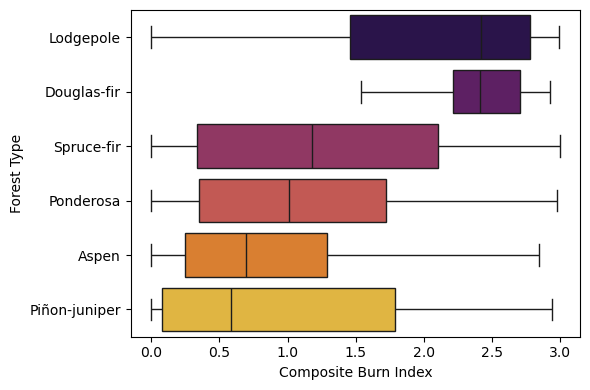


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_CBIbc_mean.png



In [15]:
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = tm_sev_d.groupby('SpeciesName')['CBIbc_mean'].median().sort_values(ascending=False)
ordered = med.index.tolist()

# create a dataframe with dominance (>90% of the same species)
dom = tm_sev_d[tm_sev_d['spp_pct'] > 80]

# plot it
plt.figure(figsize=(6, 4)) 

sns.boxplot(
    data=dom, 
    x='CBIbc_mean', 
    y='SpeciesName', 
    order=ordered, 
    palette='inferno', 
    dodge=False)

# plt.xscale('log') # log-scale FRP
plt.xlabel('Composite Burn Index')
plt.ylabel('Forest Type')
plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_CBIbc_mean.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [6]:
# Correlations between FRP and CBIbc

In [76]:
df = tm_sev_d.copy()
df = df[df['frp_csum'] > 0]
df = df[df['CBIbc_mean'] > 0]

# by forest type (grouped)
cors = {}
for tree_type, group in df.groupby('SpeciesName'):
    corr, p_value = pearsonr(group['frp_csum'], group['CBIbc_mean'])
    cors[tree_type] = (corr, p_value)
    print(f"Tree Type: {tree_type} - Pearson correlation: {corr:.2f}, p-value: {p_value:.4f}")

print(f"\n")
cor_df = pd.DataFrame(cors, index=['correlation', 'p_value']).T
print("\nCorrelation by Tree Type:\n")
cor_df = cor_df.sort_values('correlation', ascending=False)
cor_df.head(6)

Tree Type: Aspen - Pearson correlation: 0.35, p-value: 0.0000
Tree Type: Douglas-fir - Pearson correlation: 0.14, p-value: 0.0000
Tree Type: Lodgepole - Pearson correlation: 0.16, p-value: 0.0000
Tree Type: Piñon-juniper - Pearson correlation: 0.29, p-value: 0.0000
Tree Type: Ponderosa - Pearson correlation: 0.18, p-value: 0.0000
Tree Type: Spruce-fir - Pearson correlation: 0.25, p-value: 0.0000



Correlation by Tree Type:



,correlation,p_value
Aspen,0.354478,2.146347e-140
Piñon-juniper,0.293809,1.475632e-43
Spruce-fir,0.252535,1.407502e-135
Ponderosa,0.178912,9.973127e-76
Lodgepole,0.161770,7.335493e-79
Douglas-fir,0.144107,1.397793e-09


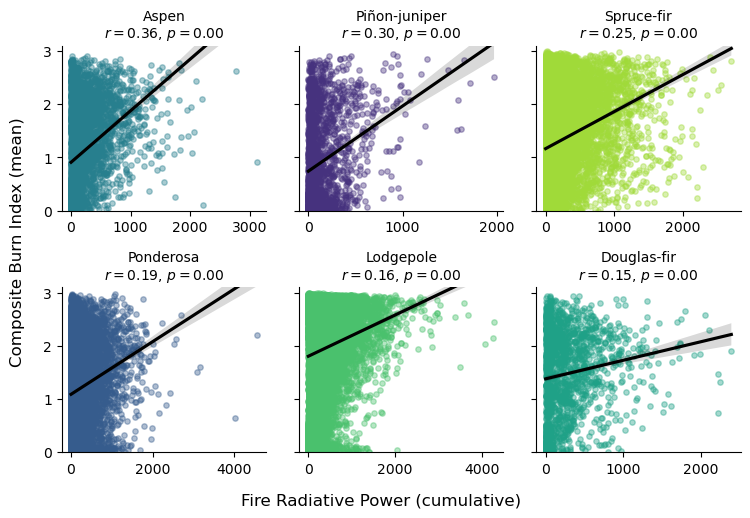

In [75]:
df = tm_sev_d.copy()
df = df[df['frp_csum'] > 0]
df = df[df['CBIbc_mean'] > 0]

sorted_species = sorted(cors.keys(), key=lambda x: abs(cors[x][0]), reverse=True)

g = sns.lmplot(
    data=df, x='frp_csum', y='CBIbc_mean', hue='SpeciesName', col='SpeciesName', 
    col_wrap=3, height=2, aspect=1.2, scatter_kws={'alpha':0.4,'s': 15}, line_kws={'color':'black'}, 
    sharey=True, sharex=False, col_order=sorted_species, palette='viridis' 
)

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    ax.set_ylim(0, df['CBIbc_mean'].max()+0.1)  # Set the y-axis limit from 0 to 4
    
    species_name = ax.get_title().replace('SpeciesName = ', '')
    corr, p_value = correlations.get(species_name, (None, None))
    
    # Set title with correlation coefficient
    ax.set_title(f"{species_name}\n$r={corr:.2f}$, $p={p_value:.2f}$", fontsize=10)

g.set_axis_labels('', '')
g.fig.text(0.5, -0.015, 'Fire Radiative Power (cumulative)', ha='center', va='center', fontsize=12)
g.fig.text(0.015, 0.85, 'Composite Burn Index (mean)', ha='center', va='center', rotation='vertical', fontsize=12)
g.fig.set_size_inches(7.5, 3)  # Set figure dimensions
plt.subplots_adjust(top=1.5)  # Adjust subplot spacing

plt.savefig(os.path.join(projdir,'figures/FigureX_SpeciesName-FRP-CBIbc.png'), dpi=150, bbox_inches='tight')

plt.show()

In [49]:
out_fp = os.path.join(projdir, 'data/tabular/mod/gridstats_frp-cbi_pearson.csv')
correlation_df.to_csv(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_frp-cbi_pearson.csv


In [50]:
# get aspen grids (any aspen component)
# get gridcells with at least some aspen
aspen_idx = tm_sev_forest[tm_sev_forest['SpeciesName'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = tm_sev_forest[tm_sev_forest['grid_index'].isin(aspen_idx)]

# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"There are a total of {n_aspen} [{round(n_aspen/len(tm_sev_forest['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

There are a total of 26992 [64.3%] gridcells with some aspen component.


Associate forest type: ['Douglas-fir', 'Lodgepole', 'Ponderosa', 'Spruce-fir', 'Piñon-juniper']



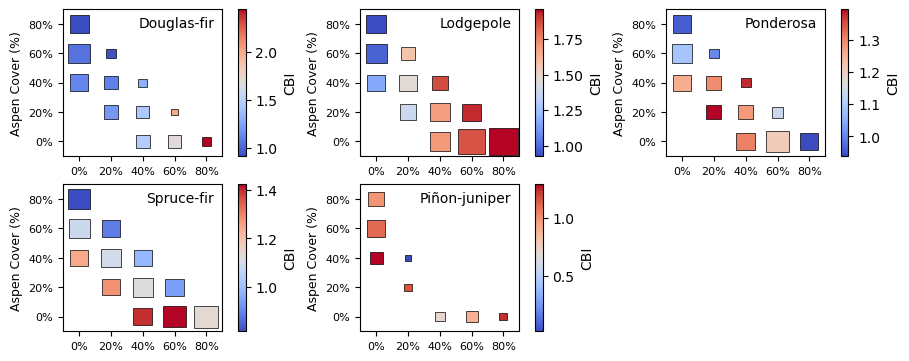

In [65]:
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['SpeciesName'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

# plot the associateions with aspen
# waffle chart version
df = grid_aspen.copy()

# create grid data
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
    )

    # make sure there is some of each kind
    cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
    cover_df = cover_df[cover_df['combined_pct'] > 60]

    # Merge with FRP data
    frp_df = grid_aspen[['grid_index', 'CBIbc_mean', 'CBIbc_p90', 'frp_max', 'frp_csum']].drop_duplicates()
    cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=range(len(bins) - 1))

    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_cbi = grouped['CBIbc_mean'].mean().reset_index(name='CBIbc')  # Mean FRP for color
    mean_frp = grouped['frp_max'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data = pd.merge(tiled_data, mean_cbi, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3 # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
axes = axes.flatten()

vmin = tiles_df['CBIbc'].min()
vmax = tiles_df['CBIbc'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    sp_vmin = sp_data['CBIbc'].min()
    sp_vmax = sp_data['CBIbc'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=sp_vmin, vmax=sp_vmax)
        color = plt.cm.coolwarm(norm(row['CBIbc']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.50, pad=0.1)
    cbar.set_label('CBI')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_CBIbc_Scaled.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

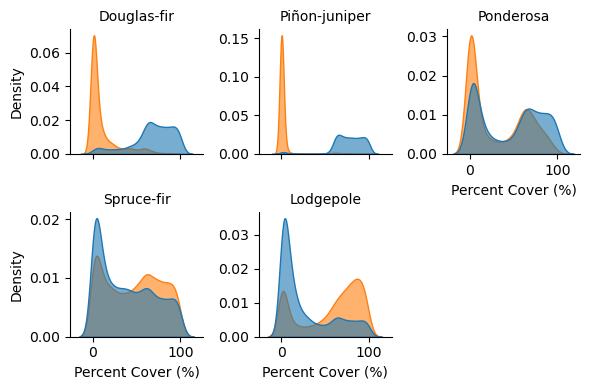

In [73]:
# plot the distribution of percent cover
df = grid_aspen.copy() # work with a copy

kde_data = []
for sp in spps:
    df_sp = df[df['SpeciesName'].isin(['Aspen', sp])]

    # Pivot table to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(index='grid_index', columns='SpeciesName', values='spp_pct', fill_value=0)
        .reset_index()
        .rename(columns={'Aspen': 'Aspen', sp: sp})
    )

    # Filter for co-occurrence
    cover_df['combined_pct'] = cover_df['Aspen'] + cover_df[sp]
    cover_df = cover_df[cover_df['combined_pct'] > 60]

    # Melt data for Seaborn FacetGrid
    melted = cover_df.melt(
        id_vars='grid_index', 
        value_vars=['Aspen', sp], 
        var_name='species', 
        value_name='pct_cover'
    )
    melted['other_spp'] = sp  # Add metadata for faceting
    kde_data.append(melted)

# Combine data for all species
kde_data_df = pd.concat(kde_data, ignore_index=True)

# FacetGrid with the fixed palette
g = sns.FacetGrid(kde_data_df, col="other_spp", col_wrap=3, height=2, sharex=True, sharey=False)

# Map kdeplot with consistent colors
g.map_dataframe(
    sns.kdeplot, 
    x="pct_cover", 
    hue="species", 
    fill=True, 
    alpha=0.6, 
    common_norm=False, 
)
    
# Adjust labels and titles
g.set_titles("{col_name}")
g.set_axis_labels("Percent Cover (%)", "Density")
g.tight_layout()

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_CoverDistribution.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

Associate forest type: ['Douglas-fir', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir', 'Lodgepole']



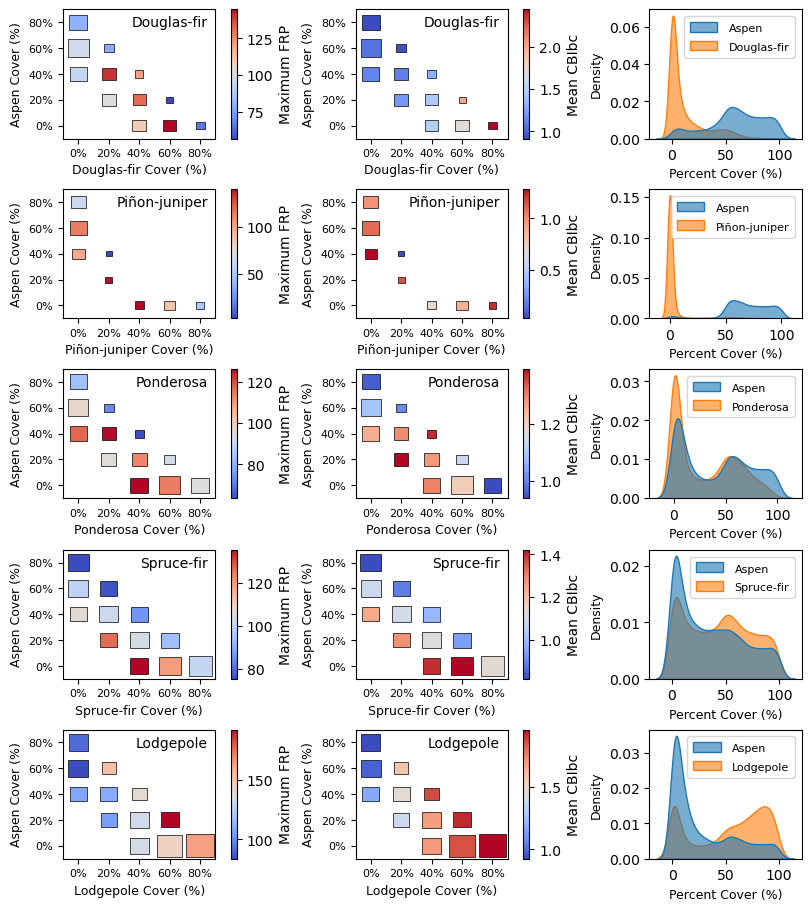

In [72]:
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['SpeciesName'].unique() if s != 'Aspen'] # exclude aspen from species list
spps = ['Douglas-fir', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir', 'Lodgepole']
print(f"Associate forest type: {spps}\n")

# Number of rows based on species
n_rows = len(spps)  # One row per species
fig, axes = plt.subplots(n_rows, 3, figsize=(8, 9), constrained_layout=True)

for i, sp in enumerate(spps):
    # ===== TILE PLOT =====
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax_tile = axes[i, 0]

    # Tile Plot Data
    sp_vmin = sp_data['frp'].min()
    sp_vmax = sp_data['frp'].max()
    norm = mcolors.Normalize(vmin=sp_vmin, vmax=sp_vmax)

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])
        y = int(row['aspen_bin'])
        size = row['tile_size'] * 0.9
        color = plt.cm.coolwarm(norm(row['frp']))

        ax_tile.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting Tile Plot
    ax_tile.text(
        0.95, 0.95, sp,  # Top-right corner
        transform=ax_tile.transAxes,
        ha='right', va='top',
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax_tile.set_xlabel(f'{sp} Cover (%)', size=9)
    ax_tile.set_ylabel('Aspen Cover (%)', size=9)
    ax_tile.set_xticks(range(len(bins) - 1))
    ax_tile.set_yticks(range(len(bins) - 1))
    ax_tile.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_xlim(-0.5, len(bins) - 1.5)
    ax_tile.set_ylim(-0.5, len(bins) - 1.5)

    # Add colorbar to tile plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_tile, orientation='vertical', fraction=0.05, pad=0.1)
    cbar.set_label('Maximum FRP')
    
    # ===== TILE PLOT =====
    ax_tile = axes[i, 1]

    # Tile Plot Data
    sp_vmin = sp_data['CBIbc'].min()
    sp_vmax = sp_data['CBIbc'].max()
    norm = mcolors.Normalize(vmin=sp_vmin, vmax=sp_vmax)

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])
        y = int(row['aspen_bin'])
        size = row['tile_size'] * 0.9
        color = plt.cm.coolwarm(norm(row['CBIbc']))

        ax_tile.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting Tile Plot
    ax_tile.text(
        0.95, 0.95, sp,  # Top-right corner
        transform=ax_tile.transAxes,
        ha='right', va='top',
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax_tile.set_xlabel(f'{sp} Cover (%)', size=9)
    ax_tile.set_ylabel('Aspen Cover (%)', size=9)
    ax_tile.set_xticks(range(len(bins) - 1))
    ax_tile.set_yticks(range(len(bins) - 1))
    ax_tile.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax_tile.set_xlim(-0.5, len(bins) - 1.5)
    ax_tile.set_ylim(-0.5, len(bins) - 1.5)

    # Add colorbar to tile plot
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    cbar = fig.colorbar(sm, ax=ax_tile, orientation='vertical', fraction=0.05, pad=0.1)
    cbar.set_label('Mean CBIbc')

    # ===== KDE PLOT =====
    sp_kde_data = kde_data_df[kde_data_df["other_spp"] == sp]
    ax_kde = axes[i, 2]

    # cp = {
    #     "Aspen": "#7fbf7b",  
    #     sp: "#af8dc3"         
    # }
   
    sns.kdeplot(data=sp_kde_data, 
        x="pct_cover", 
        hue="species", 
        fill=True, 
        alpha=0.6, 
        common_norm=False,
        # palette=cp,
        ax=ax_kde,
    )

    # Formatting KDE Plot
    # ax_kde.set_title(f'{sp}', size=10)
    ax_kde.set_xlabel('Percent Cover (%)', size=9)
    ax_kde.set_ylabel('Density', size=9)

    legend = ax_kde.legend_  # Get the legend object for the KDE plot
    if legend:
        legend.set_title("")  # Remove the legend title
        for text in legend.get_texts():  # Adjust the size of legend text
            text.set_fontsize(8)
            
# Adjust layout and show plot
# plt.tight_layout()

out_plot = os.path.join(projdir, 'figures/Figure5_CoOccurring_Heatmap_CoverDistribution_FRP_CBIbc.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()